In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from datetime import datetime

In [61]:
data = pd.read_csv('/Users/javadzabihi/Downloads/IS698 project/Reviews.csv')

In [62]:
data.tail(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...
568453,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,5,1338422400,Great Honey,"I am very satisfied ,product is as advertised,..."


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [64]:
data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [65]:
# Converting Unix time to date time
data['Time'] = pd.to_datetime(data['Time'],unit='s')

In [66]:
data.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [67]:
# "Positive" : 1, "Negative": 0
data['Sentiment'] = data['Score'].apply(lambda score: 1 if score > 3 else 0)

In [68]:
data.Sentiment.value_counts()

1    443777
0    124677
Name: Sentiment, dtype: int64

In [69]:
from nltk.stem.porter import PorterStemmer


# One way to split the text corpora into individual elements is
# to split them into individual words by splitting the cleaned documents 
# at its whitespace characters.

def tokenizer(text):
    return text.split()


# A useful technique in the context of tokenization is word stemming, which
# is the process of transforming a word into its root form. 
# It allows us to map related words to the same stem.

porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [70]:
import nltk

nltk.download('stopwords')

# Removing stop-words can be useful if we are working with raw or 
# normalized term frequencies rather than tf-idfs, which are already 
# downweighting frequently occurring words.

from nltk.corpus import stopwords

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/javadzabihi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Term Frequency-Inverse Document Frequency

When we are dealing with text data, we often encounter words that occur across multiple documents. Those frequently occurring words typically don't contain useful information. So, we can use a technique called term frequency-inverse document frequency (tf-idf) that can downweight those frequently occurring words in the feature vectors. The tf-idf can be calculated as the product of the term frequency and the inverse document frequency.

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$

$$\text{idf} (t,d) = log\frac{1 + n_d}{1 + \text{df}(d, t)}$$

$n_d$ : the total number of documents 

df(d, t) : the number of documents 'd' that contain the term 't'

In [71]:
### I'm choosing a very small subset of the dataset to speed up the run
X = data.loc[:500,'Text']
y = data.loc[:500,'Sentiment']

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Sentiment analysis

# Logistic Regression

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


###### TfidfVectorizer combines the task of CountVectorizer and TfidfTransformer.
# from sklearn.feature_extraction.text import CountVectorizer
# count = CountVectorizer()
# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf = TfidfTransformer(use_idf=True, 
#                         norm='l2', 
#                         smooth_idf=True)
# tfidf.fit_transform(count.fit_transform(text)).toarray()

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

# Using a GridSearchCV object to find the optimal set of parameters 
# for our logistic regression model.

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [74]:
gs_lr_tfidf.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

# The "best_score_" attribute returns the average score over the k-folds of the best model.
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   54.5s finished


Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x1a5cc6e840>, 'vect__use_idf': False} 
CV Accuracy: 0.828
Test Accuracy: 0.861


In [75]:
# The best grid search results using Porter stemming instead of the regular tokenizer, 
# no stop-word library, and a logistic regression classifier 
# that uses L2-regularization with the regularization strength C of 10.0
# based of raw term frequencies.
# regularization strengths is defined by the inverse-regularization parameter C.

# The "gs_lr_tfidf.best_score_" is the average k-fold cross-validation score. 
# For instance, if we have a GridSearchCV object with 10-fold cross-validation, 
# the "best_score_" attribute returns the average score over the 10-folds of the best model.


# Support Vector Classifier

In [76]:
from sklearn.svm import SVC

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [None],
               'vect__tokenizer': [tokenizer_porter],
               'clf__gamma': [0.01, 0.1, 1],
               'clf__C': [0.01, 0.1, 1.0],
               'clf__kernel': ['linear', 'rbf']}]

svc_tfidf = Pipeline([('vect', tfidf), 
                      ('clf', SVC(random_state=1))])

gs_svc_tfidf = GridSearchCV(svc_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)


In [77]:
gs_svc_tfidf.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_svc_tfidf.best_params_)

# The "best_score_" attribute returns the average score over the k-folds of the best model.
print('CV Accuracy: %.3f' % gs_svc_tfidf.best_score_)

clf = gs_svc_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   40.1s finished


Best parameter set: {'clf__C': 0.01, 'clf__gamma': 0.01, 'clf__kernel': 'linear', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x1a5cc6e840>} 
CV Accuracy: 0.818
Test Accuracy: 0.822


The best grid search results using the following values in the support vector classifier:

C = 0.01

gamma = 0.01

kernel = linear

# Naive Bayes

In [78]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                       stop_words=None,
                       tokenizer=tokenizer_porter)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred)

0.8217821782178217

# Recommendation Engine

In [79]:
data_recommender = data.loc[:, ['ProductId', 'UserId', 'Score', 'Time']]
data_recommender.head(2)

,ProductId,UserId,Score,Time
0,B001E4KFG0,A3SGXH7AUHU8GW,5,2011-04-27
1,B00813GRG4,A1D87F6ZCVE5NK,1,2012-09-07


In [80]:
# Calculating the number of unique users and products

n_users = data.UserId.unique().shape[0]   # 256059
n_products = data.ProductId.unique().shape[0] # 74258

In [81]:
# creating a dataframe with the average rating for each product

ratings = pd.DataFrame(data_recommender.groupby('ProductId')['Score'].mean())
ratings.head()

,Score
ProductId,
0006641040,4.351351
141278509X,5.000000
2734888454,3.500000
2841233731,5.000000
7310172001,4.751445


In [82]:
# Adding the number of ratings for each product to the ratings dataframe

ratings['number_of_ratings'] = data_recommender.groupby('ProductId')['Score'].count()
ratings.head()

,Score,number_of_ratings
ProductId,,
0006641040,4.351351,37
141278509X,5.000000,1
2734888454,3.500000,2
2841233731,5.000000,1
7310172001,4.751445,173


In [83]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,Score,number_of_ratings
ProductId,,
B007JFMH8M,4.582694,913
B0026RQTGE,4.588608,632
B002QWHJOU,4.588608,632
B002QWP89S,4.588608,632
B002QWP8H0,4.588608,632
B003B3OOPA,4.739968,623
B001EO5Q64,4.746032,567
B0026KPDG8,4.310284,564
B000VK8AVK,4.310284,564


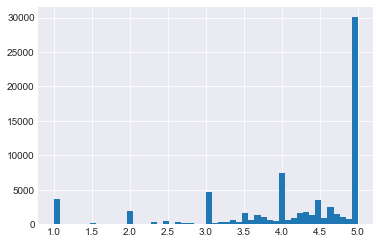

In [84]:
ratings['Score'].hist(bins=50)

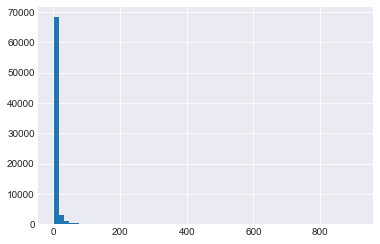

In [85]:
ratings['number_of_ratings'].hist(bins=60)

/Applications/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


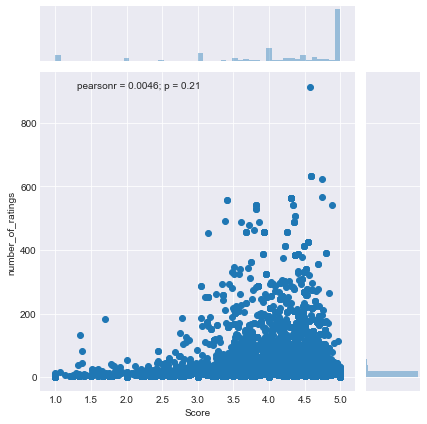

In [86]:
sns.jointplot(x='Score', y='number_of_ratings', data=ratings)

# Collaborative filtering

In [87]:
data_recommender.head()

,ProductId,UserId,Score,Time
0,B001E4KFG0,A3SGXH7AUHU8GW,5,2011-04-27
1,B00813GRG4,A1D87F6ZCVE5NK,1,2012-09-07
2,B000LQOCH0,ABXLMWJIXXAIN,4,2008-08-18
3,B000UA0QIQ,A395BORC6FGVXV,2,2011-06-13
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,2012-10-21


In [88]:
X_rec = data_recommender.loc[:1000,['ProductId', 'UserId', 'Score']]
y_rec = data_recommender.loc[:1000,'UserId']

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_rec, y_rec, test_size=0.2, random_state=42)

In [90]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [91]:
# Defining the baseline model to always return 3.
def baseline(user_id, product_id):
    return 3.0

In [92]:
def score(cf_model):
    
    # Constructing a list of user-product tuples from the testing dataset
    id_pairs = zip(X_test['UserId'], X_test['ProductId'] )
    
    # Predicting the score for every user-product tuple
    y_pred = np.array([cf_model(user, product) for (user, product) in id_pairs])
    
    # Extracting the actual ratings given by the users in the testing dataset
    y_true = np.array(X_test['Score'])
    
    # Returning the rsme score
    return rmse(y_true, y_pred)



In [93]:
# We will try to build a recommender system with a score lower than our baseline model.
score(baseline)

1.7661831686081222

In [94]:
# Building a ratings matrix where each row represents a user,
# each column represents a product, and the values are the scores.
# Then the value in the ith row and jth column will denote the score
# given by user i to product j.

r_matrix = X_train.pivot_table(index = 'UserId', columns = 'ProductId', values = 'Score')

r_matrix.head(2)

ProductId,B0002567IW,B00029XIZI,B0002XIB2Y,B00061KYVI,B00067AD4U,B0007NG568,B0007NG56I,B0009XLVG0,B0009XLVGA,B000C21OOM,...,B007TFONH0,B007ZENY5W,B00813GRG4,B0081XN2HQ,B00821UN4M,B0087HW5E2,B0089PI9OC,B008BEGP9W,B0093NIWVO,B009HINRX8
UserId,,,,,,,,,,,,,,,,,,,,,
A104Y49ZQ4CYJ2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A108P30XVUFKXY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
# User-based collaborative filtering using mean of scores
# Assigning equal wights to all users when calculating the score

def cf_user_mean(UserId, ProductId):
    # Check if product exists in r_matrix
    if ProductId in r_matrix:
        # Compute the mean of all the scores given to that product
        mean_rating = r_matrix[ProductId].mean()
        
    else:
        # Default to a rating of 3.0 in the absence of any information
        mean_rating = 3.0
        
    return mean_rating



In [96]:
# RMSE for the mean model
# the score is better than the baseline model
score(cf_user_mean)

1.3446551627203842

In [97]:
# Weighted mean
# It's better to give a higher weight to those users whose scores are similar
# to the user in question.
# Using cosine similarity function
# Cosine similarity function does not work with NaN values.
# Therfore we need to convert all missing values in the r_matrix to zero.

r_matrix_dummy = r_matrix.copy().fillna(0)

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(r_matrix_dummy, r_matrix_dummy)

cosine_sim = pd.DataFrame(cosine_sim, index = r_matrix.index, columns = r_matrix.index)

cosine_sim.head(2)

UserId,A104Y49ZQ4CYJ2,A108P30XVUFKXY,A10EHUTGNC4BGP,A11LJJL1SOH6W0,A11QUNPSCNHY62,A11UPZ6LI1UJZY,A11VPI6WLMQ2ZQ,A12OF4IM7A8YS,A12T0F58OKHCIW,A137DV4YVGWDCR,...,AYAU6OMJ81Q7Z,AYB4ELCS5AM8P,AYMV2T86WIXVD,AYSEXV27DPQ3E,AYZZSRYAIXNOS,AZ2NEHE8TNRUW,AZ3FPU1QSFBC6,AZ7289G0ILRFF,AZLONLC8OZPEC,AZOF9E17RGZH8
UserId,,,,,,,,,,,,,,,,,,,,,
A104Y49ZQ4CYJ2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A108P30XVUFKXY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
# User-based collaborative filtering using weighted mean ratings
def cf_user_wmean(UserId, ProductId):
    
    # check if product exists in r_matrix
    if ProductId in r_matrix:
        
        # Get the similarity scores for the user in question with every other user
        sim_scores = cosine_sim[UserId]
        
        # Get the user ratings for the product in question
        p_ratings = r_matrix[ProductId]
        
        # Extract the indices with NaN value in the p_ratings series
        idx = p_ratings[p_ratings.isnull()].index
        
        # Drop the NaN values from p_ratings series
        p_ratings = p_ratings.dropna()
        
        # Drop the corresponding cosine scores from the sim_scores series
        sim_scores = sim_scores.drop(idx)
        
        # Compute the final weighted mean
        wmean_rating = np.dot(sim_scores, p_ratings) / sim_scores.sum()
        
    else:
        
        # Default to a rating of 3.0 in the absence of any information
        wmean_rating = 3.0
        
    return wmean_rating
        



In [99]:
data_surprise = data_recommender.loc[:1000 , ['UserId', 'ProductId', 'Score']]

In [100]:
data_surprise.head()

,UserId,ProductId,Score
0,A3SGXH7AUHU8GW,B001E4KFG0,5
1,A1D87F6ZCVE5NK,B00813GRG4,1
2,ABXLMWJIXXAIN,B000LQOCH0,4
3,A395BORC6FGVXV,B000UA0QIQ,2
4,A1UQRSCLF8GW1T,B006K2ZZ7K,5


In [101]:
from surprise import Reader, Dataset, KNNBasic, evaluate

reader = Reader()

dataset = Dataset.load_from_df(data_surprise, reader)

knn = KNNBasic()

evaluate(knn, dataset, measures = ['RMSE'])

Evaluating RMSE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2221
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3039
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2843
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4116
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4043
------------
------------
Mean RMSE: 1.3253
------------
------------


/Applications/anaconda3/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/Applications/anaconda3/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


CaseInsensitiveDefaultDict(list,
                           {'rmse': [1.222142217629038,
                             1.3038711606801334,
                             1.2843168980261181,
                             1.4116192583116947,
                             1.404319281203137]})

In [102]:
from surprise import SVD

svd = SVD()

evaluate(svd, dataset, measures = ['RMSE'])


/Applications/anaconda3/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/Applications/anaconda3/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 1.2046
------------
Fold 2
RMSE: 1.2868
------------
Fold 3
RMSE: 1.2639
------------
Fold 4
RMSE: 1.3673
------------
Fold 5
RMSE: 1.3625
------------
------------
Mean RMSE: 1.2970
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [1.2045996993505002,
                             1.2867908854365315,
                             1.2639376317723963,
                             1.3673304730292244,
                             1.3624886611277198]})